In [1]:
import numpy as np
from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss, WeightedSmoothL1Loss
from torchmetrics import R2Score

import json
import torch
import pandas as pd
from torch.utils.data import DataLoader
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import os

import seaborn as sns
sns.set(style="whitegrid")


from bondnet.data.dataset import ReactionNetworkDatasetGraphs

from bondnet.model.gated_reaction_network_lightning import (
    GatedGCNReactionNetworkLightning,
)

from bondnet.utils import seed_torch, pickle_dump, parse_settings
from bondnet.model.training_utils import (
    evaluate_breakdown,
    get_grapher,
    load_model_lightning,
)
from bondnet.data.dataloader import DataLoaderReactionNetwork
from bondnet.data.dataset import ReactionNetworkDatasetGraphs
from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss, WeightedSmoothL1Loss

In [34]:
def get_dataset(
    train_path="../../dataset/HEPOM/Filtered_train_set_alchemy_qm9.json",
    test_path="../../dataset/HEPOM/Filtered_test_set_alchemy_qm9.json",
):
    # train_df_path = "../../dataset/Training_set_HEPoP_after_filtering.json"
    # test_df_path = "/home/rdguha95/Holdout_test_set_HEPoP_after_filtering.json"
    train_df = pd.read_json(train_path)
    test_df = pd.read_json(test_path)
    frames = [train_df, test_df]
    full_df = pd.concat(frames)
    full_df.reset_index(inplace=True)
    full_df.drop(columns="index", inplace=True)
    full_df = full_df.drop_duplicates(subset=["reaction_id"])
    full_df = full_df.reset_index(drop=True)
    return full_df, test_df, train_df


def evaluate(model, nodes, data_loader, device=None):
    """
    basic loop for training a classifier. Gets mae

    Args:
        model(pytorch model): pytorch model
        nodes(dict): node feature dictionary
        data_loader(loader obj): loader object with data to eval
        device(str): cpu/gpu
    Returns:
        mae(float): mae
    """
    metric_fn = WeightedL1Loss(reduction="sum")
    model.eval()

    dict_result_raw = {}

    with torch.no_grad():
        count, mae, mae_no_std = 0.0, 0.0, 0.0
        for batched_graph, label in data_loader:
            feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in nodes}
            target = label["value"]
            norm_atom = label["norm_atom"]
            # norm_atom = None
            norm_bond = label["norm_bond"]
            # norm_bond = None
            stdev = label["scaler_stdev"]
            reaction_types = label["reaction_types"]
            # print device batched_graph is on
            # move batched_graph to device
            batched_graph = batched_graph.to(device)
            if device is not None:
                feats = {k: v.to(device) for k, v in feats.items()}
                target = target.to(device)
                norm_atom = norm_atom.to(device)
                norm_bond = norm_bond.to(device)
                stdev = stdev.to(device)
            functional_group_reacted = [
                i.extra_info["functional_group_reacted"] for i in label["reaction"]
            ]

            pred = model(
                graph=batched_graph,
                feats=feats,
                reactions=label["reaction"],
                norm_atom=norm_atom,
                norm_bond=norm_bond,
                reverse=False,
            )

            pred = pred.view(-1)

            if device is None:
                pred_np = pred.detach().numpy()
                target_np = target.detach().numpy()
                stdev_np = stdev.detach().numpy()
            else:
                pred_np = pred.detach().cpu().numpy()
                target_np = target.detach().cpu().numpy()
                stdev_np = stdev.detach().cpu().numpy()

            t1 = torch.tensor(pred_np)
            t2 = torch.tensor(target_np)
            t2 = t2.squeeze()
            r2score = R2Score()
            sc = r2score(t1, t2)
            target_np = target_np.reshape(-1)
            x = pred_np * stdev_np
            y = target_np * stdev_np
            print(x.shape, y.shape)
            # plt.scatter(pred_np, target_np)
            #plt.scatter(x, y)
            df_pred = pd.DataFrame([x, y, stdev_np, functional_group_reacted])

            # Show each performance with scatter plots
            # sns.scatterplot(x=pred_np * stdev_np,y=target_np * stdev_np, palette="Set3", inner="points", bw =.2, cut=2, linewidth=3)

            min_val = (
                np.min([np.min(pred_np * stdev_np), np.min(target_np * stdev_np)]) - 0.5
            )
            max_val = (
                np.max([np.max(pred_np * stdev_np), np.max(target_np * stdev_np)]) + 0.5
            )
            """plt.ylim(min_val, max_val)
            plt.xlim(min_val, max_val)
            # plt.ylim(-10, 10)
            # plt.xlim(-10, 10)
            plt.title("Predicted vs. True")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.grid(False)
            # plt.savefig("./{}.png".format("test_best"))
            """
            mae += metric_fn(pred, target, stdev).detach().item()
            mae_no_std += metric_fn(pred, target, None).detach().item()
            count += len(target)

    l1_acc = mae / count
    l1_acc_no_std = mae_no_std / count
    return l1_acc, l1_acc_no_std, sc, df_pred

full_df, test_df, train_df = get_dataset()

In [3]:
#test_df["functional_group_reacted"] = test_df[
#    "extra_feat_global_reactant_functional_group_reacted"
#]
# test_df["extra_feat_global_product_functional_group_reacted"] = [None] * len(test_df)

In [3]:
torch.set_float32_matmul_precision("high")
from bondnet.test_utils import get_defaults

config = get_defaults()
config["model"]["extra_features"] = ["bond_length", "functional_group_reacted"]
# config["model"]["extra_features"] = ["bond_length", "functional_group_reacted"]

In [4]:
config["model"]

{'conv': 'GatedGCNConv',
 'readout': 'Set2SetThenCat',
 'augment': False,
 'classifier': False,
 'classif_categories': 3,
 'cat_weights': [1.0, 1.0, 1.0],
 'embedding_size': 4,
 'epochs': 100,
 'extra_features': ['bond_length', 'functional_group_reacted'],
 'extra_info': [],
 'filter_species': [3, 5],
 'fc_activation': 'ReLU',
 'fc_batch_norm': False,
 'fc_dropout': 0.2,
 'fc_hidden_size_1': 64,
 'fc_hidden_size_shape': 'flat',
 'fc_num_layers': 1,
 'gated_activation': 'ReLU',
 'gated_batch_norm': False,
 'gated_dropout': 0.1,
 'gated_graph_norm': False,
 'gated_hidden_size_1': 10,
 'gated_hidden_size_shape': 'flat',
 'gated_num_fc_layers': 1,
 'gated_num_layers': 2,
 'gated_residual': True,
 'learning_rate': 0.001,
 'precision': 'bf16',
 'loss': 'mse',
 'num_lstm_iters': 3,
 'num_lstm_layers': 1,
 'restore': False,
 'weight_decay': 0.0,
 'max_epochs': 1000,
 'max_epochs_transfer': 10,
 'transfer': False,
 'filter_outliers': True,
 'freeze': True,
 'reactant_only': False,
 'initializer

In [5]:
dataset = ReactionNetworkDatasetGraphs(
    grapher=get_grapher(
        {
            "atom": [], 
            "bond": ["bond_length"], 
            "global": ["functional_group_reacted"]

        }
    ),
    file="../../dataset/HEPOM/Filtered_test_set_alchemy_qm9.json",
    target="dG_sp",
    classifier=False,
    classif_categories=3,
    filter_species=[10, 10],
    filter_outliers=False,
    filter_sparse_rxns=False,
    debug=False,
    extra_keys=        {
            "atom": [], 
            "bond": ["bond_length"], 
            "global": ["functional_group_reacted"]

        },
    extra_info=["functional_group_reacted"],
)
test_dataset_loader = DataLoaderReactionNetwork(
    dataset, batch_size=len(dataset), shuffle=False
)

fg_list ['PDK', 'amide', 'carbamate', 'carboxylic acid ester', 'cyclic carbonate', 'epoxide', 'imide', 'lactam', 'lactone', 'nitrile', 'urea']
reading file from: ../../dataset/HEPOM/Filtered_test_set_alchemy_qm9.json
rxn raw len: 4000
Program finished in 65.65169899689499 seconds
.............failures.............
reactions len: 4000
valid ind len: 4000
bond break fail count: 		0
default fail count: 		0
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 4000
---> generating grouped reactions


grouped reactions: 100%|██████████| 4000/4000 [02:22<00:00, 28.12it/s]


--> generating labels


labeled reactions: 100%|██████████| 4000/4000 [00:00<00:00, 6080.65it/s] 


features: 12226
labels: 4000
molecules: 12226
constructing graphs & features....


mol graphs: 100%|██████████| 12226/12226 [00:35<00:00, 342.63it/s]


number of graphs valid: 12226
number of graphs: 12226


In [6]:
dataset.molecules[0].functional_group

'lactone'

In [50]:

models_list = os.listdir(
    "/home/santiagovargas/dev/HEPOM/data/models/neutral_0226_hepom/"
)

for model_name in models_list:

    config["restore"] = True
    #model_path = "/home/santiagovargas/dev/HEPOM/data/models/neutral_0226_hepom/model_lightning_epoch=160-val_l1=2.31.ckpt"
    model_path = "/home/santiagovargas/dev/HEPOM/data/models/neutral_0226_hepom/" + model_name
    config["restore_path"] = model_path
    model_restart = load_model_lightning(config, load_dir=model_path)
    # load model to gpu
    model_restart.cuda()
    
    feature_names = ["atom", "bond", "global"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    l1, l1_no_std, sc, df_pred = evaluate(
        model_restart, feature_names, test_dataset_loader, device=device
    )

    sns_data = df_pred.T
    sns_data = sns_data.rename(
        columns={
            0: "bondnet_prediction",
            1: "dft_value",
            2: "std_dev",
            3: "functional_group_reacted",
        }
    )
        
    mae = np.abs(np.array(sns_data["bondnet_prediction"] - sns_data["dft_value"])).mean()
    bondnet_pred = list(sns_data["bondnet_prediction"].to_numpy().reshape(-1))
    dft_val = list(sns_data["dft_value"].to_numpy().reshape(-1))

    r2 = np.corrcoef(bondnet_pred, dft_val)[0, 1]**2
    print("Model: {} MAE: {:.4f} R2: {:.4f}".format(model_name, mae, r2))

:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
NB: using Mean
:::MODEL LOADED:::


(4000,) (4000,)
Model: model_lightning_epoch=160-val_l1=2.26.ckpt MAE: 2.5933 R2: 0.8250
:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
NB: using Mean
:::MODEL LOADED:::


/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:85: UserWarning: Input size (torch.Size([4000])) is different from the target size (torch.Size([4000, 1])) or weight size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  warnings.warn(
/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:82: UserWarning: Using a target size (torch.Size([4000, 1])) that is different to the input size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


(4000,) (4000,)
Model: last-v1.ckpt MAE: 2.5316 R2: 0.8264
:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
NB: using Mean
:::MODEL LOADED:::


/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:85: UserWarning: Input size (torch.Size([4000])) is different from the target size (torch.Size([4000, 1])) or weight size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  warnings.warn(
/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:82: UserWarning: Using a target size (torch.Size([4000, 1])) that is different to the input size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


(4000,) (4000,)
Model: last-v19.ckpt MAE: 2.6408 R2: 0.8219
:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
NB: using Attention
:::MODEL LOADED:::


/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:85: UserWarning: Input size (torch.Size([4000])) is different from the target size (torch.Size([4000, 1])) or weight size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  warnings.warn(
/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:82: UserWarning: Using a target size (torch.Size([4000, 1])) that is different to the input size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


(4000,) (4000,)
Model: model_lightning_epoch=458-val_l1=2.30.ckpt MAE: 2.5461 R2: 0.8071
:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
NB: using Mean
:::MODEL LOADED:::


/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:85: UserWarning: Input size (torch.Size([4000])) is different from the target size (torch.Size([4000, 1])) or weight size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  warnings.warn(
/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:82: UserWarning: Using a target size (torch.Size([4000, 1])) that is different to the input size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


(4000,) (4000,)
Model: model_lightning_epoch=181-val_l1=2.14.ckpt MAE: 2.5185 R2: 0.8229
:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
NB: using Attention
:::MODEL LOADED:::


/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:85: UserWarning: Input size (torch.Size([4000])) is different from the target size (torch.Size([4000, 1])) or weight size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  warnings.warn(
/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:82: UserWarning: Using a target size (torch.Size([4000, 1])) that is different to the input size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


(4000,) (4000,)
Model: last-v23.ckpt MAE: 2.5398 R2: 0.8071


/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:85: UserWarning: Input size (torch.Size([4000])) is different from the target size (torch.Size([4000, 1])) or weight size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  warnings.warn(
/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:82: UserWarning: Using a target size (torch.Size([4000, 1])) that is different to the input size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [52]:
#last-v1.ckpt

#model_lightning_epoch=458-val_l1=2.30.ckpt

config["restore"] = True
#model_path = "/home/santiagovargas/dev/HEPOM/data/models/neutral_0226_hepom/model_lightning_epoch=160-val_l1=2.31.ckpt"
model_path = "/home/santiagovargas/dev/HEPOM/data/models/neutral_0226_hepom/model_lightning_epoch=181-val_l1=2.14.ckpt" 
config["restore_path"] = model_path
model_restart = load_model_lightning(config, load_dir=model_path)
# load model to gpu
model_restart.cuda()

feature_names = ["atom", "bond", "global"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
l1, l1_no_std, sc, df_pred = evaluate(
    model_restart, feature_names, test_dataset_loader, device=device
)

sns_data = df_pred.T
sns_data = sns_data.rename(
    columns={
        0: "bondnet_prediction",
        1: "dft_value",
        2: "std_dev",
        3: "functional_group_reacted",
    }
)

mae = np.abs(np.array(sns_data["bondnet_prediction"] - sns_data["dft_value"])).mean()
bondnet_pred = list(sns_data["bondnet_prediction"].to_numpy().reshape(-1))
dft_val = list(sns_data["dft_value"].to_numpy().reshape(-1))

r2 = np.corrcoef(bondnet_pred, dft_val)[0, 1]**2
print("Model: {} MAE: {:.4f} R2: {:.4f}".format(model_name, mae, r2))

:::RESTORING MODEL FROM EXISTING FILE:::
NB: using GatedGCNConv
NB: using Mean
:::MODEL LOADED:::


(4000,) (4000,)
Model: last-v23.ckpt MAE: 2.5185 R2: 0.8229


/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:85: UserWarning: Input size (torch.Size([4000])) is different from the target size (torch.Size([4000, 1])) or weight size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  warnings.warn(
/home/santiagovargas/dev/bondnet/bondnet/model/metric.py:82: UserWarning: Using a target size (torch.Size([4000, 1])) that is different to the input size (torch.Size([4000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [63]:
mae = np.abs(np.array(sns_data["bondnet_prediction"] - sns_data["dft_value"])).mean()
print(mae)
mae = np.abs(np.array(sns_data["bondnet_prediction"] - sns_data["dft_value"])).mean()
bondnet_pred = list(sns_data["bondnet_prediction"].to_numpy().reshape(-1))
r2 = np.corrcoef(bondnet_pred, dft_val)[0, 1]**2
print(r2)

rmse = np.abs(np.array(sns_data["bondnet_prediction"] - sns_data["dft_value"]))**2
rmse = np.mean(rmse)**(0.5)
print(rmse)

2.5185268
0.822907397689494
5.980211600214712


/tmp/ipykernel_928047/2674168095.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), size=15)
/tmp/ipykernel_928047/2674168095.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size=15)


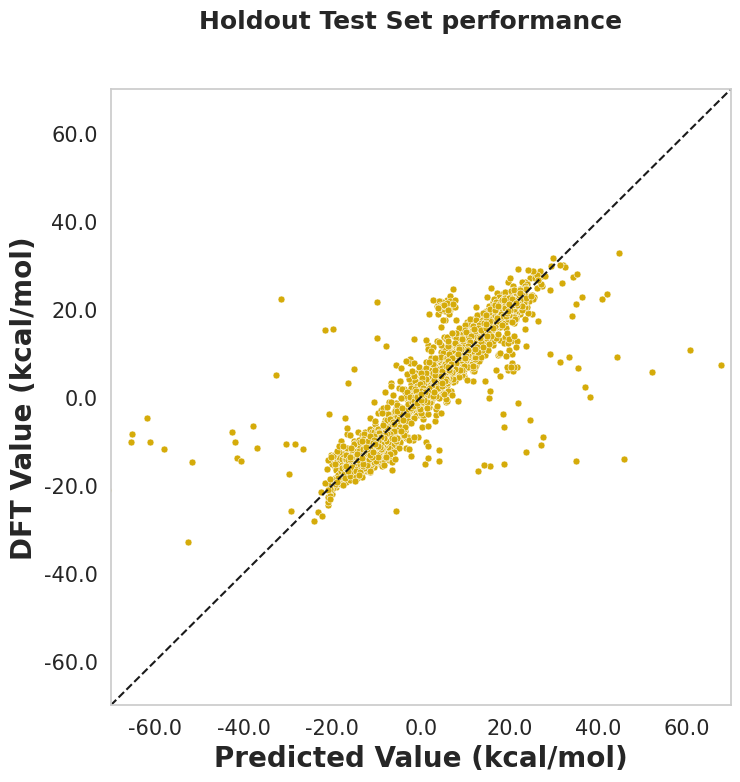

In [54]:
f, ax = plt.subplots(figsize=(8, 8))
sns.set(style="whitegrid")
ax = sns.scatterplot(
    x="dft_value",
    y="bondnet_prediction",
    data=sns_data,
    marker="o",
    s=25,
    color=sns.xkcd_rgb["burnt yellow"],
)


f.suptitle("Holdout Test Set performance", fontsize=18, fontweight="bold")
ax.set_xlabel("Predicted Value (kcal/mol)", size=20, alpha=1, weight="bold")
ax.set_ylabel("DFT Value (kcal/mol)", size=20, alpha=1, weight="bold")
ax.set_xlim(-70, 70)
ax.set_ylim(-70, 70)

ax.set_yticklabels(ax.get_yticks(), size=15)
ax.set_xticklabels(ax.get_xticks(), size=15)
plt.grid(False)
X_plot = np.linspace(-70, 70, 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, "k--")
plt.show()

In [55]:
adj_factor = sns_data["dft_value"][0] - test_df["dG_sp"][0]
sns_data["mean_shifted_dft"] = sns_data["dft_value"] - adj_factor
sns_data["deviation"] = abs(sns_data["dft_value"] - sns_data["bondnet_prediction"])

sns_ten_fg_subset = sns_data[
    sns_data["functional_group_reacted"].isin(
        [
            "epoxide",
            "lactone",
            "nitrile",
            "amide",
            "lactam",
            "carboxylic acid ester",
            "urea",
            "imide",
            "carbamate",
            "cyclic carbonate",
        ]
    )
]

/tmp/ipykernel_928047/3819157396.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), size=15, weight="bold")
/tmp/ipykernel_928047/3819157396.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size=15, weight="bold")


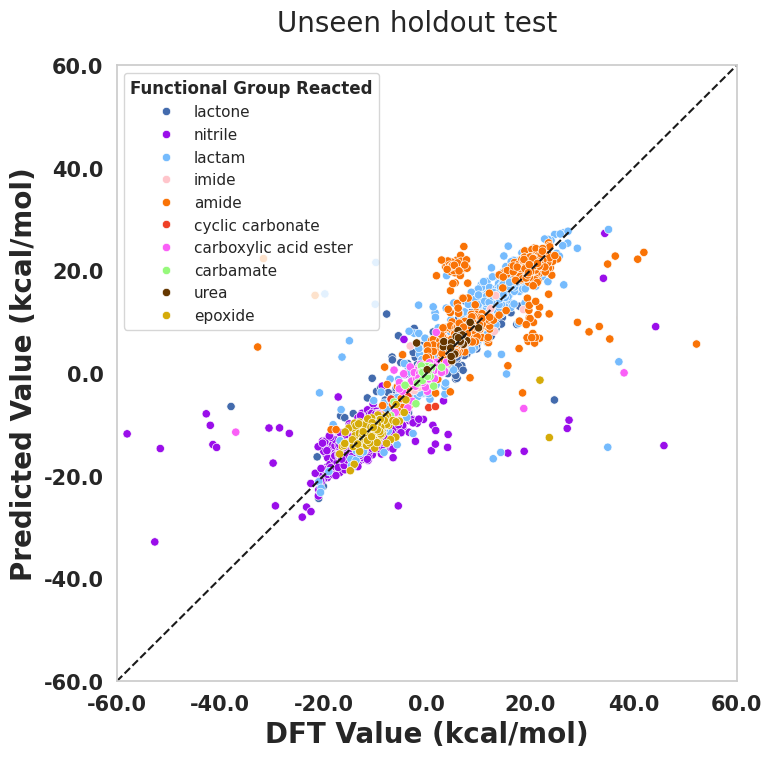

In [56]:
f, ax = plt.subplots(figsize=(8, 8))
sns.set(style="whitegrid")

sns.set_palette("pastel")

ax = sns.scatterplot(
    x="dft_value",
    y="bondnet_prediction",
    data=sns_ten_fg_subset,
    marker="o",
    hue="functional_group_reacted",
    palette=[
        sns.xkcd_rgb["french blue"],
        sns.xkcd_rgb["violet"],
        sns.xkcd_rgb["sky blue"],
        sns.xkcd_rgb["light rose"],
        sns.xkcd_rgb["orange"],
        sns.xkcd_rgb["tomato"],
        sns.xkcd_rgb["light magenta"],
        sns.xkcd_rgb["light green"],
        sns.xkcd_rgb["brown"],
        sns.xkcd_rgb["burnt yellow"],
    ],
)
f.suptitle("Unseen holdout test", y=0.95, fontsize=20)

ax.set_xlabel("DFT Value (kcal/mol)", size=20, alpha=1, weight="bold")
ax.set_ylabel("Predicted Value (kcal/mol)", size=20, alpha=1, weight="bold")
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)


legend = ax.legend(loc="upper left", title="Functional Group Reacted")
legend.get_title().set_fontsize("12")  # Set font size
legend.get_title().set_fontweight("bold")  # Set font weight
ax.set_yticklabels(ax.get_yticks(), size=15, weight="bold")
ax.set_xticklabels(ax.get_xticks(), size=15, weight="bold")
plt.grid(False)
X_plot = np.linspace(-60, 60, 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, "k--")
plt.savefig("Holdout_test_set.png", dpi=600)
plt.show()

In [57]:
# compute the mean absolute error of each functional group
fg_mae = sns_ten_fg_subset.groupby("functional_group_reacted").mean()["deviation"]
fg_mae

functional_group_reacted
amide                    2.848662
carbamate                1.356016
carboxylic acid ester    2.688345
cyclic carbonate         2.506003
epoxide                  2.044225
imide                    2.260105
lactam                   3.538269
lactone                  2.907926
nitrile                  1.999846
urea                     1.543203
Name: deviation, dtype: object

In [58]:
fg_mae = sns_ten_fg_subset["deviation"].mean()
print(fg_mae)

2.5410228645419646


In [59]:
for functional_group in list(
    set(sns_ten_fg_subset["functional_group_reacted"].tolist())
):
    # get the subset of the data for each functional group
    fg_subset = sns_ten_fg_subset[
        sns_ten_fg_subset["functional_group_reacted"] == functional_group
    ]
    # compute r2 between dft and bondnet prediction
    t1 = torch.tensor(fg_subset["bondnet_prediction"].tolist())
    t2 = torch.tensor(fg_subset["dft_value"].tolist())
    t2 = t2.squeeze()
    r2score = R2Score()
    sc = r2score(t1, t2)
    # print("{}:\t\t\t{}".format(functional_group, sc))
    # print with uniform spacing
    if len(functional_group) >= 23:
        print("{}:\t{}".format(functional_group, sc))
    if len(functional_group) >= 15:
        print("{}:\t\t{}".format(functional_group, sc))
    elif len(functional_group) >= 7:
        print("{}:\t\t\t{}".format(functional_group, sc))
    else:
        print("{}:\t\t\t\t{}".format(functional_group, sc))

nitrile:			0.31396347284317017
cyclic carbonate:		-0.172440767288208
carbamate:			0.5309499502182007
urea:				0.2657235264778137
epoxide:			0.1878402829170227
carboxylic acid ester:		0.19636237621307373
lactone:			0.5510815382003784
imide:				0.7021307945251465
amide:				0.5162484645843506
lactam:				0.5778049230575562
